# Predict effect of surgery based upon observational data 

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
from data import load_amp, load_uke
import numpy as np
from treeffuser import Treeffuser

from sklearn.metrics import RocCurveDisplay
from sklearn.covariance import MinCovDet
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
PDQ_COLUMNS = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]
COVARIATES = ["Time since diagnosis", "Age", "Sex"]
EXTRA_COVARIATES = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "MoCA"]
SEED = 37


def cast_to_float(data):
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors="coerce")
    return data


def preprocess_covariates(data):
    data = data.copy()
    data["Sex"] = data["Sex"].map({"Male": 0.0, "Female": 1.0})
    data = cast_to_float(data)
    return data


def parse_data(y, covariates):
    data = pd.concat(
        (y[["Participant", "Study", "Visit ID", *PDQ_COLUMNS, *EXTRA_COVARIATES]], covariates[COVARIATES]), axis=1
    ).dropna(thresh=4 + len(COVARIATES) + len(EXTRA_COVARIATES))
    data["Visit ID"] = data["Visit ID"].str[1:].astype(int)
    data = data[data["Study"] != "HBS"]
    
    X = []
    y = []
    extra_data = []
    
    for _, data in data.sort_values(
        ["Participant", "Visit ID"], ascending=True
    ).groupby(["Participant"]):
        for iloc, (_, row) in enumerate(data.iterrows()):
            if iloc > 0:
                previous_row = data.iloc[iloc - 1]
                previous_row = previous_row[PDQ_COLUMNS].to_list() + [
                    (row["Visit ID"] - previous_row["Visit ID"]) / 12.0
                ]
            else:
                previous_row = [np.nan] * (len(PDQ_COLUMNS) + 1)

            X.append(previous_row + row[COVARIATES].to_list() + row[EXTRA_COVARIATES].to_list())
            y.append(row[PDQ_COLUMNS])
            extra_data.append([row["Study"]])
            
    return preprocess_covariates(
        pd.DataFrame(X, columns=PDQ_COLUMNS + ["Time since last visit"] + COVARIATES + EXTRA_COVARIATES)
    ), cast_to_float(pd.DataFrame(y, columns=PDQ_COLUMNS).reset_index(drop=True)), pd.DataFrame(extra_data, columns=["Study"])

# Load the AMP data
X_amp, covariates_amp = load_amp(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp_all.csv",
    sample_one_measurement_per_subject=False,
)
X_amp, y_amp, extra_data_amp = parse_data(X_amp, covariates_amp)

# Load the UKE data
X_uke, covariates_uke, extra_data_uke, y_uke = load_uke(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv",
    PDQ_COLUMNS + EXTRA_COVARIATES,
)

X_uke = pd.concat(
    (
        X_uke,
        extra_data_uke[["Time since last test"]].rename(
            columns={"Time since last test": "Time since last visit"}
        ),
        covariates_uke[COVARIATES],
    ),
    axis=1,
)
full_measurements_uke = pd.isna(X_uke).sum(axis=1) < 4
X_uke = preprocess_covariates(X_uke)[full_measurements_uke]
covariates_uke = covariates_uke[full_measurements_uke]
extra_data_uke = extra_data_uke[full_measurements_uke]
y_uke = y_uke[full_measurements_uke]

## Find the best generative model

import properscoring

INDICES_TEST_SET = extra_data_amp["Study"] == "Sure"

X_amp_train = X_amp[~INDICES_TEST_SET]
y_amp_train = y_amp[~INDICES_TEST_SET]
X_amp_test = X_amp[INDICES_TEST_SET]s
y_amp_test = y_amp[INDICES_TEST_SET]

model = Treeffuser(seed=SEED)
model.fit(X_amp_train.to_numpy().astype(np.float32), y_amp_train.to_numpy().astype(np.float32))
y_samples = model.sample(X_amp_test.to_numpy().astype(np.float32), 100, seed=SEED)

results = pd.DataFrame(properscoring.crps_ensemble(
    y_amp_test.to_numpy().astype(np.float32),
    np.clip(y_samples, 0, 100),
    axis=0,
), columns=PDQ_COLUMNS, index=X_amp_test.index)
results["Covariates only"] = pd.isna(X_amp_test[PDQ_COLUMNS]).sum(axis=1) == len(PDQ_COLUMNS)
results = results.melt(id_vars="Covariates only", var_name="Subscore", value_name="CRPS")
sns.catplot(data=results, x="Subscore", y="CRPS", hue="Covariates only", kind="point", alpha=0.5)

## Fit the generative model and calculate the baseline

In [3]:
baseline_data = pd.DataFrame.from_dict(
    {
        "pre_pdq": X_uke[PDQ_COLUMNS].mean(axis=1),
        "updrs_iii_change": extra_data_uke["UPDRS III: Change"],
        "diagnosis_time": covariates_uke["Time since diagnosis"],
        "improvement": (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) > 10.9).astype(float),
    }
)

baseline = smf.logit(
    "improvement ~ pre_pdq + updrs_iii_change + diagnosis_time", data=baseline_data
).fit()

Optimization terminated successfully.
         Current function value: 0.514690
         Iterations 6


In [4]:
def generate_samples(model, covariates, n_samples: int = 500, seed: int = 42):
    predicted = np.clip(
        model.sample(
            covariates.to_numpy().astype(np.float32), n_samples=n_samples, seed=seed
        ),
        0,
        100,
    )
    return pd.concat(
        [
            pd.DataFrame(predicted[:, i, :], columns=PDQ_COLUMNS).assign(
                Subject=subject_id, Sample=list(range(predicted.shape[0]))
            )
            for i, (subject_id, _) in enumerate(covariates.iterrows())
        ],
        ignore_index=True,
    )

model = Treeffuser(seed=SEED)
model.fit(X_amp.to_numpy().astype(np.float32), y_amp.to_numpy().astype(np.float32))
X_uke_masked = X_uke.copy()
X_uke_masked[PDQ_COLUMNS] = np.nan
X_uke_predicted = generate_samples(model, X_uke_masked, n_samples=500, seed=SEED)
y_uke_predicted = generate_samples(model, X_uke, n_samples=500, seed=SEED)

## Evaluate different "simple" predictions

In [5]:
samples_mahalanobis = []
for (subject_id, ground_truth) in X_uke.iterrows():
    robust_cov = MinCovDet(random_state=SEED).fit(X_uke_predicted[X_uke_predicted["Subject"] == subject_id][PDQ_COLUMNS].to_numpy())
    distance = robust_cov.mahalanobis(
        ground_truth[PDQ_COLUMNS].to_numpy().reshape(1, -1)
    )[0] ** (0.33)
    samples_mahalanobis.append((subject_id, distance))

samples_mahalanobis = pd.DataFrame.from_records(
    samples_mahalanobis, columns=["Subject ID", "mahalanobis"]
).set_index("Subject ID")
samples_mahalanobis["improvement"] = (
    (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1)) > 10.9
).astype(float)
samples_mahalanobis["pre_pdq"] = X_uke[PDQ_COLUMNS].mean(axis=1)

mahalanobis = smf.logit("improvement ~ mahalanobis", data=samples_mahalanobis).fit()

Optimization terminated successfully.
         Current function value: 0.651328
         Iterations 6


In [6]:
samples_improvement_ratio = []
for (subject_id, ground_truth) in X_uke.iterrows():
    difference = ((ground_truth[PDQ_COLUMNS].mean() - y_uke_predicted[y_uke_predicted["Subject"] == subject_id][PDQ_COLUMNS].mean(axis=1)) > 10.9).mean()
    samples_improvement_ratio.append((subject_id, difference))
    
samples_improvement_ratio = pd.DataFrame.from_records(
    samples_improvement_ratio, columns=["Subject ID", "chance_for_improvement"]
).set_index("Subject ID")
samples_improvement_ratio["improvement"] = (
    (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1)) > 10.9
).astype(float)
samples_improvement_ratio["pre_pdq"] = X_uke[PDQ_COLUMNS].mean(axis=1)

improvement_ratio = smf.logit("improvement ~ chance_for_improvement", data=samples_improvement_ratio).fit()

Optimization terminated successfully.
         Current function value: 0.547398
         Iterations 5


Optimization terminated successfully.
         Current function value: 0.517388
         Iterations 6


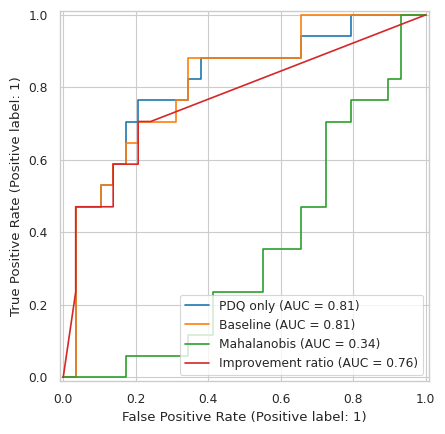

In [7]:
pdq_only = smf.logit("improvement ~ pre_pdq", data=samples_mahalanobis).fit()

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        samples_mahalanobis["improvement"],
        pdq_only.predict(samples_mahalanobis),
        name="PDQ only",
    )

    viz = RocCurveDisplay.from_predictions(
        baseline_data["improvement"],
        baseline.predict(baseline_data),
        name="Baseline",
        ax=viz.ax_,
    )
    
    viz = RocCurveDisplay.from_predictions(
        samples_mahalanobis["improvement"],
        mahalanobis.predict(samples_mahalanobis),
        name="Mahalanobis",
        ax=viz.ax_,
    )
    
    viz = RocCurveDisplay.from_predictions(
        samples_improvement_ratio["improvement"],
        improvement_ratio.predict(samples_improvement_ratio),
        name="Improvement ratio",
        ax=viz.ax_,
    )

## Calculate the differences between observed and predicted values

/home/vscode/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/home/vscode/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


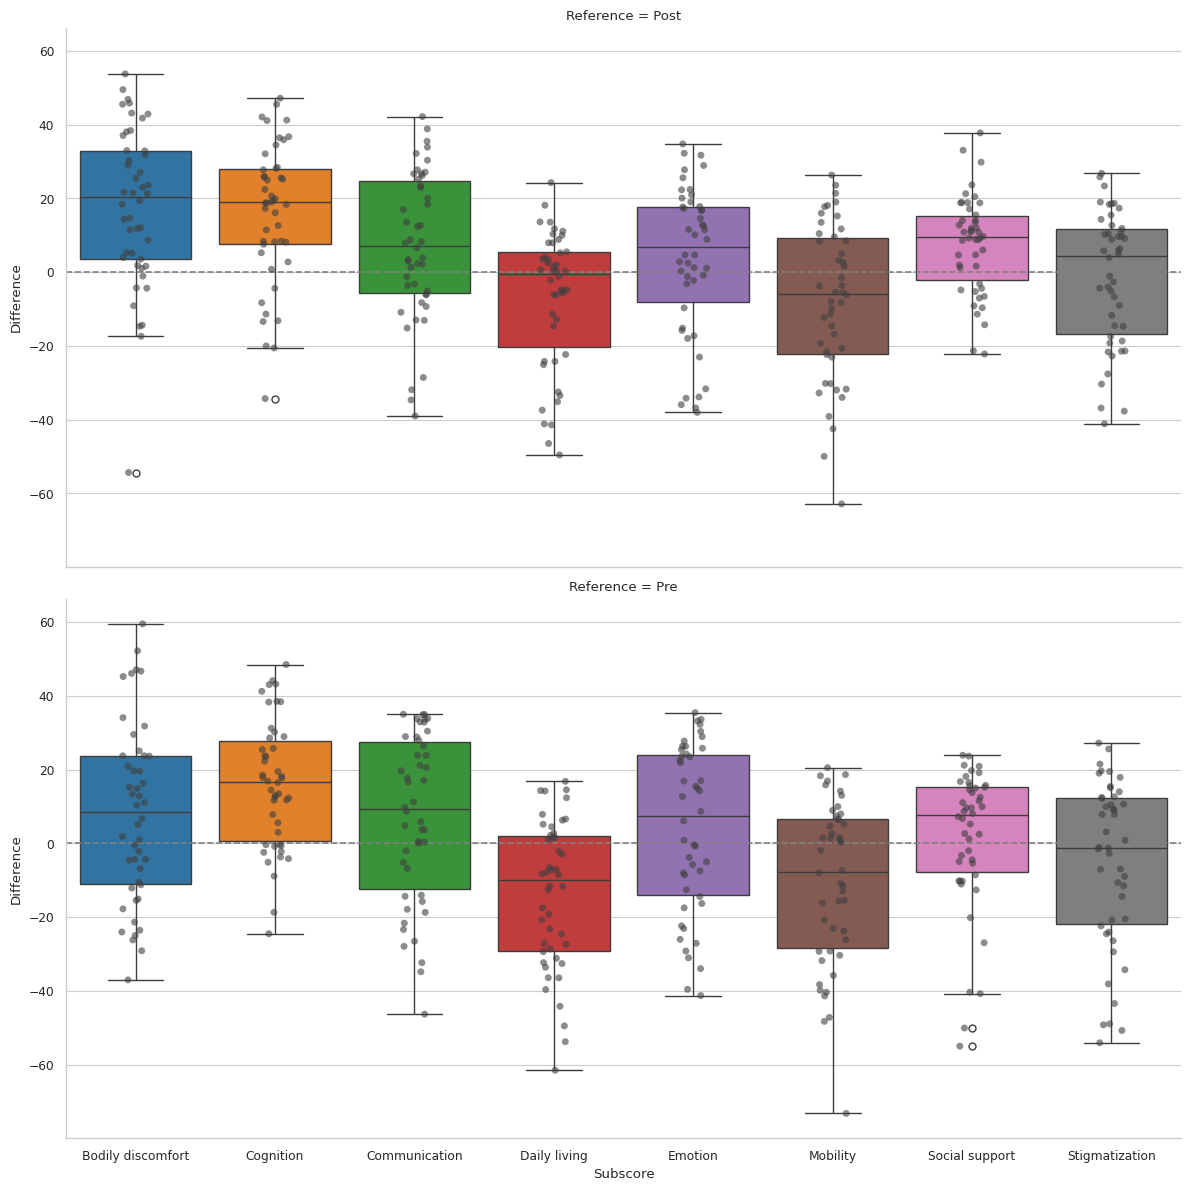

In [41]:
def calculate_relative_difference(baseline, generated_data):
    return pd.concat(
        [
            ((generated_data[generated_data["Subject"] == subject][PDQ_COLUMNS]) - baseline_data[PDQ_COLUMNS]).assign(
                Subject=subject,
                Sample=generated_data[generated_data["Subject"] == subject]["Sample"]
            )
            for subject, baseline_data in baseline.iterrows()
        ],
        ignore_index=True,
    ).melt(id_vars=["Subject", "Sample"], var_name="Subscore", value_name="Difference")

relative_difference_pre = calculate_relative_difference(X_uke, X_uke_predicted)
relative_difference_post = calculate_relative_difference(y_uke, y_uke_predicted)

relative_difference_combined = pd.concat([relative_difference_pre.assign(Reference="Pre"), relative_difference_post.assign(Reference="Post")], ignore_index=True)
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    g = sns.catplot(
        relative_difference_combined.groupby(["Subscore", "Subject", "Reference"]).mean().reset_index(),
        x="Subscore",
        y="Difference",
        hue="Subscore",
        height=6,
        aspect=2,
        kind="box",
        row="Reference",
    )
    g.map_dataframe(sns.stripplot, x="Subscore", y="Difference", palette=["#404040"], alpha=0.6)
    g.refline(y=0)

## Calculate difference to baseline

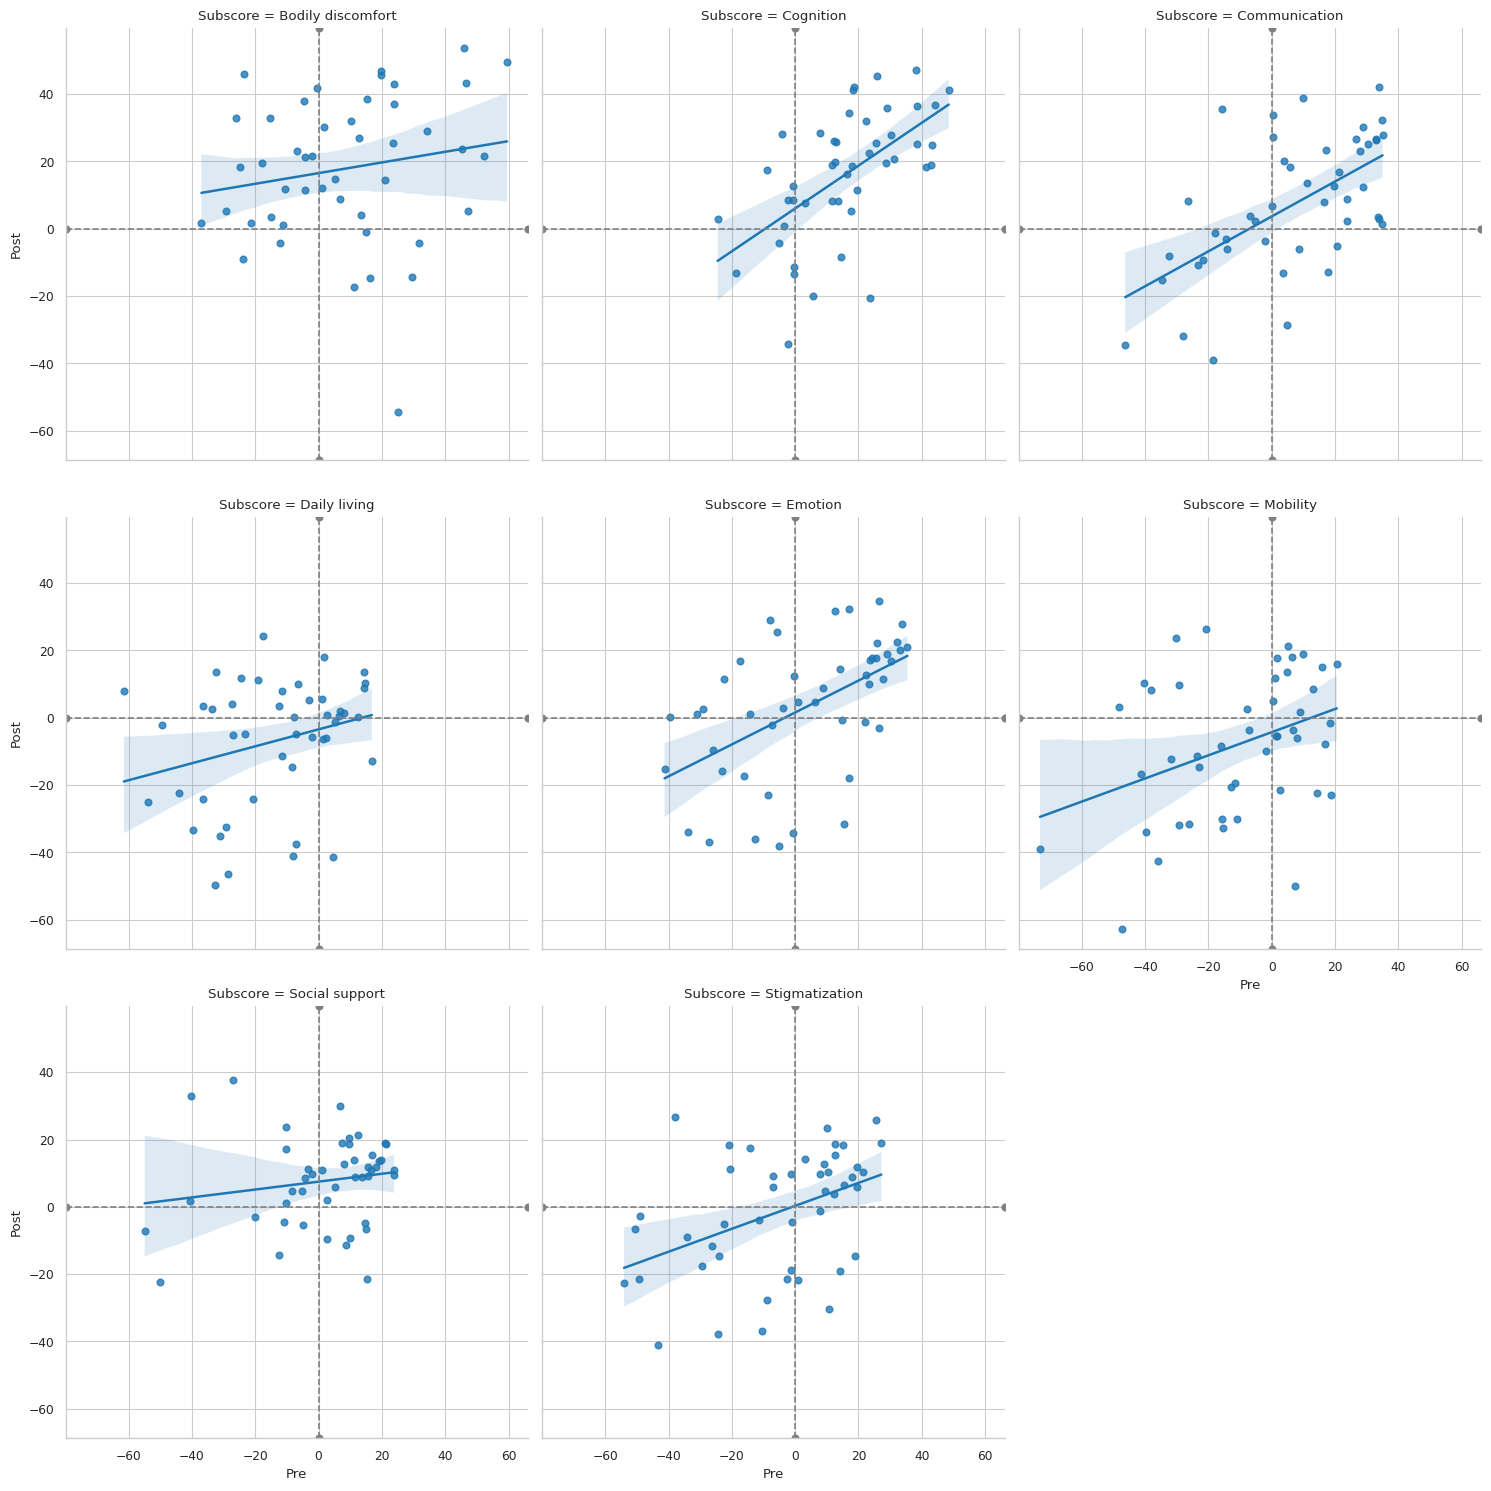

In [ ]:
median_diff_X_uke = relative_difference_pre.groupby(["Subscore", "Subject"]).mean().reset_index().drop(columns=["Sample"]).pivot(index=["Subject"], columns=["Subscore"], values="Difference")
median_diff_y_uke = relative_difference_post.groupby(["Subscore", "Subject"]).mean().reset_index().drop(columns=["Sample"]).pivot(index=["Subject"], columns=["Subscore"], values="Difference")

pre_post_comparison = median_diff_X_uke.reset_index().melt(id_vars=["Subject"], var_name="Subscore", value_name="Difference").set_index(["Subject", "Subscore"]).rename(columns={"Difference": "Pre"}).join(median_diff_y_uke.reset_index().melt(id_vars=["Subject"], var_name="Subscore", value_name="Difference").set_index(["Subject", "Subscore"]).rename(columns={"Difference": "Post"})).reset_index()
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    fig = sns.lmplot(pre_post_comparison, x="Pre", y="Post", col="Subscore", col_wrap=3, order=1, robust=False)
    fig.refline(x=0, y=0)

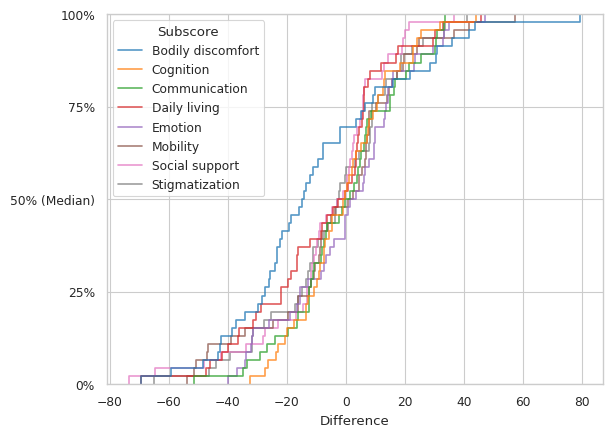

In [43]:
pre_post_comparison["Difference"] = pre_post_comparison["Pre"] - pre_post_comparison["Post"]

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    ax = sns.ecdfplot(data=pre_post_comparison, x="Difference", hue="Subscore", alpha=0.75)
    
    ax.set_yticks((0, 0.25, 0.5, 0.75, 1.0))
    ax.set_yticklabels(("0%", "25%", "50% (Median)", "75%", "100%"))
    ax.set_ylabel("")

In [121]:
from sklearn.linear_model import LinearRegression

y_uke_predicted_adjusted = y_uke_predicted.copy()

# Add the offset between observed measurement and predicted measurements
for row, data in median_diff_X_uke.iterrows():
    y_uke_predicted_adjusted.loc[y_uke_predicted_adjusted["Subject"] == row, PDQ_COLUMNS] += data.to_numpy()
y_uke_predicted_adjusted[PDQ_COLUMNS] = y_uke_predicted_adjusted[PDQ_COLUMNS].clip(0, 100)
y_uke_predicted_adjusted = y_uke_predicted_adjusted.join(pd.DataFrame(X_uke[PDQ_COLUMNS].mean(axis=1).rename("Pre PDQ")), on="Subject")
y_uke_predicted_adjusted["Post PDQ: Predicted (no adjustment)"] = y_uke_predicted_adjusted[PDQ_COLUMNS].mean(axis=1)
y_uke_predicted_adjusted["Improvement: Predicted (no adjustment)"] = (y_uke_predicted_adjusted["Pre PDQ"] - y_uke_predicted_adjusted["Post PDQ: Predicted (no adjustment)"]) > 10.9

# Add an intercept
intercepts = pd.Series({ group: (data["Post"] - 1.0 * data["Pre"]).mean() for group, data in pre_post_comparison.groupby("Subscore") })
y_uke_predicted_adjusted[PDQ_COLUMNS] -= intercepts[PDQ_COLUMNS]
y_uke_predicted_adjusted[PDQ_COLUMNS] = y_uke_predicted_adjusted[PDQ_COLUMNS].clip(0, 100)
y_uke_predicted_adjusted["Post PDQ: Predicted (intercept)"] = y_uke_predicted_adjusted[PDQ_COLUMNS].mean(axis=1)
y_uke_predicted_adjusted["Improvement: Predicted (intercept)"] = (y_uke_predicted_adjusted["Pre PDQ"] - y_uke_predicted_adjusted["Post PDQ: Predicted (intercept)"]) > 10.9

# Add only the intercept
y_uke_predicted_adjusted[PDQ_COLUMNS] = y_uke_predicted[PDQ_COLUMNS]
y_uke_predicted_adjusted[PDQ_COLUMNS] -= intercepts[PDQ_COLUMNS]
y_uke_predicted_adjusted[PDQ_COLUMNS] = y_uke_predicted_adjusted[PDQ_COLUMNS].clip(0, 100)
y_uke_predicted_adjusted["Post PDQ: Predicted (intercept only)"] = y_uke_predicted_adjusted[PDQ_COLUMNS].mean(axis=1)
y_uke_predicted_adjusted["Improvement: Predicted (intercept only)"] = (y_uke_predicted_adjusted["Pre PDQ"] - y_uke_predicted_adjusted["Post PDQ: Predicted (intercept only)"]) > 10.9

# Add a full linear regression
predictors = { score: LinearRegression().fit(X=data[["Pre"]], y=data[["Post"]]) for score, data in pre_post_comparison.groupby("Subscore") }
y_uke_predicted_adjusted[PDQ_COLUMNS] = y_uke_predicted[PDQ_COLUMNS]
for row, data in median_diff_X_uke.iterrows():
    individual_offset = pd.Series({ score: model.predict(pd.DataFrame([data[score]], columns=["Pre"]))[0][0] for score, model in predictors.items() })
    y_uke_predicted_adjusted.loc[y_uke_predicted_adjusted["Subject"] == row, PDQ_COLUMNS] -= individual_offset
y_uke_predicted_adjusted[PDQ_COLUMNS] = y_uke_predicted_adjusted[PDQ_COLUMNS].clip(0, 100)
y_uke_predicted_adjusted["Post PDQ: Predicted (regression)"] = y_uke_predicted_adjusted[PDQ_COLUMNS].mean(axis=1)
y_uke_predicted_adjusted["Improvement: Predicted (regression)"] = (y_uke_predicted_adjusted["Pre PDQ"] - y_uke_predicted_adjusted["Post PDQ: Predicted (regression)"]) > 10.9

# The columns are now messed up
y_uke_predicted_adjusted = y_uke_predicted_adjusted.drop(columns=PDQ_COLUMNS)

samples_constant_adjustment = pd.DataFrame.from_dict({
    "predicted_improvement_no_adjustment": y_uke_predicted_adjusted.groupby("Subject")["Improvement: Predicted (no adjustment)"].mean(),
    "predicted_improvement_intercept": y_uke_predicted_adjusted.groupby("Subject")["Improvement: Predicted (intercept)"].mean(),
    "predicted_improvement_intercept_only": y_uke_predicted_adjusted.groupby("Subject")["Improvement: Predicted (intercept only)"].mean(),
    "predicted_improvement_regression": y_uke_predicted_adjusted.groupby("Subject")["Improvement: Predicted (regression)"].mean(),
    "observed_change": (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1)) 
})
samples_constant_adjustment["improvement"] = (samples_constant_adjustment["observed_change"] > 10.9).astype(float)

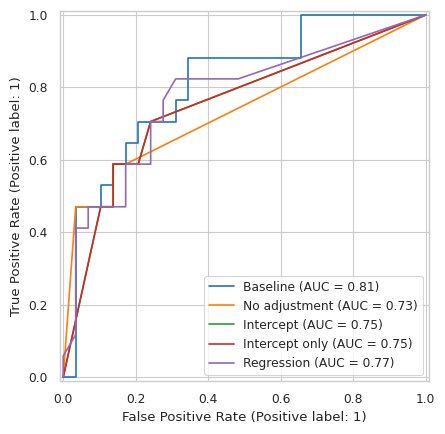

In [122]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        baseline_data["improvement"],
        baseline.predict(baseline_data),
        name="Baseline",
    )

    viz = RocCurveDisplay.from_predictions(
        samples_constant_adjustment["improvement"],
        samples_constant_adjustment["predicted_improvement_no_adjustment"],
        name="No adjustment",
        ax=viz.ax_
    )
    
    viz = RocCurveDisplay.from_predictions(
        samples_constant_adjustment["improvement"],
        samples_constant_adjustment["predicted_improvement_intercept"],
        name="Intercept",
        ax=viz.ax_
    )
    
    viz = RocCurveDisplay.from_predictions(
        samples_constant_adjustment["improvement"],
        samples_constant_adjustment["predicted_improvement_intercept"],
        name="Intercept only",
        ax=viz.ax_
    )
    
    viz = RocCurveDisplay.from_predictions(
        samples_constant_adjustment["improvement"],
        samples_constant_adjustment["predicted_improvement_regression"],
        name="Regression",
        ax=viz.ax_
    )

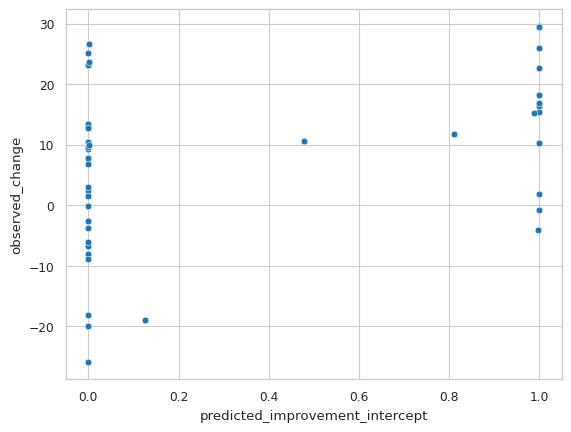

In [85]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.scatterplot(samples_constant_adjustment, x="predicted_improvement_intercept", y="observed_change")